# Klasifikasi Emosi dengan RNN-GRU.ipynb

Pada notebook ini akan dbangun model NN untuk klasifikasi RNN-GRU dengan data text tweet yang sudah dibersihkan sebelumnya

**Import Library**

In [213]:
import pandas as pd
import numpy as np

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
import seaborn

## Load Data

In [214]:
df = pd.read_csv("https://raw.githubusercontent.com/eliyantojoko/emotion_classification_GRU/refs/heads/main/preprocessed_dataset_adjustdikit.csv")

In [215]:
data = df[["refined_tweet", "label"]]

In [216]:
data

,refined_tweet,label
0,soal jalan jatibarupolisi bisa gertak gubernur...,anger
1,sesama cewek lho kayaknya harusnya rasain haru...,anger
2,kepingin gudeg mbarek bu hj amad foto google s...,happy
3,jalan jatibarubagian wilayah tn abangpengatura...,anger
4,sharing pengalaman aja kemarin jam batalin tik...,happy
...,...,...
4396,tahukah saat papa memejamkan matanya menahan g...,love
4397,sulitnya menetapkan calon wapresnya jokowi pil...,fear
4398,masa depannya jelas lha iya gimana mau jelas c...,anger
4399,benar mahasiswa teknik ui nembak pacarnya sahu...,happy


In [217]:
import re

# Buat fungsi untuk langkah case folding
def casefolding(text):
    text = re.sub(r'\n', ' ', text)                        # Menghilangkan Enter
    text = re.sub(r'\bhttps?\S*\b', ' ', text)             # Menghilangkan kata yang mengandung http atau https
    text = re.sub(r'\s+', ' ', text)                       # Mengganti spasi ganda menjadi spasi tunggal
    text = text.lower()                                    # Mengubah huruf menjadi huruf kecil
    text = text.replace(":", " ")                          # Hapus :
    text = re.sub(r'@\w+\s*', ' ', text)                   # Menghapus kata yang diawali dengan @
    text = re.sub(r'[-+]?[0-9]+', ' ', text)               # Menghapus angka
    text = re.sub(r'[^\w\s]', ' ', text)                   # Menghapus karakter tanda baca
    text = text.strip()                                    # Menghapus whitespace di awal dan di akhir
    return text

data["casefolding"] = data["refined_tweet"].apply(lambda x: casefolding(x))
data.head()


,refined_tweet,label,casefolding
0,soal jalan jatibarupolisi bisa gertak gubernur...,anger,soal jalan jatibarupolisi bisa gertak gubernur...
1,sesama cewek lho kayaknya harusnya rasain haru...,anger,sesama cewek lho kayaknya harusnya rasain haru...
2,kepingin gudeg mbarek bu hj amad foto google s...,happy,kepingin gudeg mbarek bu hj amad foto google s...
3,jalan jatibarubagian wilayah tn abangpengatura...,anger,jalan jatibarubagian wilayah tn abangpengatura...
4,sharing pengalaman aja kemarin jam batalin tik...,happy,sharing pengalaman aja kemarin jam batalin tik...


In [218]:
key_norm = pd.read_csv("key_norm.csv")
def text_normalize(text):
    text = ' '.join([key_norm[key_norm['singkat'] == word]['hasil'].values[0] if (key_norm['singkat'] == word).any() else word for word in text.split()])
    text = str.lower(text)
    return text
data['textnormalize'] = data['casefolding'].apply(text_normalize)
data.head()


,refined_tweet,label,casefolding,textnormalize
0,soal jalan jatibarupolisi bisa gertak gubernur...,anger,soal jalan jatibarupolisi bisa gertak gubernur...,soal jalan jatibarupolisi bisa gertak gubernur...
1,sesama cewek lho kayaknya harusnya rasain haru...,anger,sesama cewek lho kayaknya harusnya rasain haru...,sesama cewek lho kayaknya harusnya rasain haru...
2,kepingin gudeg mbarek bu hj amad foto google s...,happy,kepingin gudeg mbarek bu hj amad foto google s...,kepingin gudeg mbarek bu hj amad foto google s...
3,jalan jatibarubagian wilayah tn abangpengatura...,anger,jalan jatibarubagian wilayah tn abangpengatura...,jalan jatibarubagian wilayah tn abangpengatura...
4,sharing pengalaman aja kemarin jam batalin tik...,happy,sharing pengalaman aja kemarin jam batalin tik...,sharing pengalaman saja kemarin jam batalin ti...


In [219]:
# download Stopwords bahasa indonesia
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\BISRI_MUSTAFA\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [220]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords


stopwords_ind = stopwords.words('indonesian')
print(stopwords_ind)

['ada', 'adalah', 'adanya', 'adapun', 'agak', 'agaknya', 'agar', 'akan', 'akankah', 'akhir', 'akhiri', 'akhirnya', 'aku', 'akulah', 'amat', 'amatlah', 'anda', 'andalah', 'antar', 'antara', 'antaranya', 'apa', 'apaan', 'apabila', 'apakah', 'apalagi', 'apatah', 'artinya', 'asal', 'asalkan', 'atas', 'atau', 'ataukah', 'ataupun', 'awal', 'awalnya', 'bagai', 'bagaikan', 'bagaimana', 'bagaimanakah', 'bagaimanapun', 'bagi', 'bagian', 'bahkan', 'bahwa', 'bahwasanya', 'baik', 'bakal', 'bakalan', 'balik', 'banyak', 'bapak', 'baru', 'bawah', 'beberapa', 'begini', 'beginian', 'beginikah', 'beginilah', 'begitu', 'begitukah', 'begitulah', 'begitupun', 'bekerja', 'belakang', 'belakangan', 'belum', 'belumlah', 'benar', 'benarkah', 'benarlah', 'berada', 'berakhir', 'berakhirlah', 'berakhirnya', 'berapa', 'berapakah', 'berapalah', 'berapapun', 'berarti', 'berawal', 'berbagai', 'berdatangan', 'beri', 'berikan', 'berikut', 'berikutnya', 'berjumlah', 'berkali-kali', 'berkata', 'berkehendak', 'berkeinginan'

In [221]:
def remove_stop_words(text):
    clean_words = []
    text = text.split()
    for word in text:
        if word not in stopwords_ind:
            clean_words.append(word)
    return " ".join(clean_words)
data['stopwordremoval'] = data['textnormalize'].apply(remove_stop_words)
data.head()

,refined_tweet,label,casefolding,textnormalize,stopwordremoval
0,soal jalan jatibarupolisi bisa gertak gubernur...,anger,soal jalan jatibarupolisi bisa gertak gubernur...,soal jalan jatibarupolisi bisa gertak gubernur...,jalan jatibarupolisi gertak gubernur emangny p...
1,sesama cewek lho kayaknya harusnya rasain haru...,anger,sesama cewek lho kayaknya harusnya rasain haru...,sesama cewek lho kayaknya harusnya rasain haru...,cewek lho kayaknya rasain sibuk jaga rasain sa...
2,kepingin gudeg mbarek bu hj amad foto google s...,happy,kepingin gudeg mbarek bu hj amad foto google s...,kepingin gudeg mbarek bu hj amad foto google s...,kepingin gudeg mbarek bu hj amad foto google s...
3,jalan jatibarubagian wilayah tn abangpengatura...,anger,jalan jatibarubagian wilayah tn abangpengatura...,jalan jatibarubagian wilayah tn abangpengatura...,jalan jatibarubagian wilayah tn abangpengatura...
4,sharing pengalaman aja kemarin jam batalin tik...,happy,sharing pengalaman aja kemarin jam batalin tik...,sharing pengalaman saja kemarin jam batalin ti...,sharing pengalaman kemarin jam batalin tiket s...


In [222]:
from tqdm import tqdm
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# Set up the stemming factory
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Buat fungsi untuk langkah stemming bahasa Indonesia
def stemming(text):
    return stemmer.stem(text)

# Tambahkan support untuk tqdm pada pandas
tqdm.pandas()

# Terapkan stemming dengan tqdm untuk melihat progress
data['stemming'] = data['stopwordremoval'].progress_apply(stemming)


# Lihat hasilnya
data.head()

100%|██████████| 4401/4401 [11:51<00:00,  6.18it/s]


,refined_tweet,label,casefolding,textnormalize,stopwordremoval,stemming
0,soal jalan jatibarupolisi bisa gertak gubernur...,anger,soal jalan jatibarupolisi bisa gertak gubernur...,soal jalan jatibarupolisi bisa gertak gubernur...,jalan jatibarupolisi gertak gubernur emangny p...,jalan jatibarupolisi gertak gubernur emangny p...
1,sesama cewek lho kayaknya harusnya rasain haru...,anger,sesama cewek lho kayaknya harusnya rasain haru...,sesama cewek lho kayaknya harusnya rasain haru...,cewek lho kayaknya rasain sibuk jaga rasain sa...,cewek lho kayak rasain sibuk jaga rasain sakit...
2,kepingin gudeg mbarek bu hj amad foto google s...,happy,kepingin gudeg mbarek bu hj amad foto google s...,kepingin gudeg mbarek bu hj amad foto google s...,kepingin gudeg mbarek bu hj amad foto google s...,kepingin gudeg mbarek bu hj amad foto google s...
3,jalan jatibarubagian wilayah tn abangpengatura...,anger,jalan jatibarubagian wilayah tn abangpengatura...,jalan jatibarubagian wilayah tn abangpengatura...,jalan jatibarubagian wilayah tn abangpengatura...,jalan jatibarubagian wilayah tn abangpengatura...
4,sharing pengalaman aja kemarin jam batalin tik...,happy,sharing pengalaman aja kemarin jam batalin tik...,sharing pengalaman saja kemarin jam batalin ti...,sharing pengalaman kemarin jam batalin tiket s...,sharing alam kemarin jam batalin tiket stasiun...


In [223]:
data["clean_text"] = data['stemming']
data.drop(["casefolding","textnormalize","stopwordremoval","stemming"],axis=1,inplace=True)
data.head()

,refined_tweet,label,clean_text
0,soal jalan jatibarupolisi bisa gertak gubernur...,anger,jalan jatibarupolisi gertak gubernur emangny p...
1,sesama cewek lho kayaknya harusnya rasain haru...,anger,cewek lho kayak rasain sibuk jaga rasain sakit...
2,kepingin gudeg mbarek bu hj amad foto google s...,happy,kepingin gudeg mbarek bu hj amad foto google s...
3,jalan jatibarubagian wilayah tn abangpengatura...,anger,jalan jatibarubagian wilayah tn abangpengatura...
4,sharing pengalaman aja kemarin jam batalin tik...,happy,sharing alam kemarin jam batalin tiket stasiun...


## Data Preprocessing

Pada tahap ini akan dilakukan encoding, atau kodifikasi kolom `label` menjadi numerikal agar dapat diproses lebih lanjut

### 1. Label Encoding

In [224]:
import warnings 
warnings.filterwarnings('ignore')

label_encoder = LabelEncoder()
data['label'] = label_encoder.fit_transform(data['label'])  # Mengubah label ke bentuk numerik
num_classes = len(label_encoder.classes_)

In [225]:
data.head()

,refined_tweet,label,clean_text
0,soal jalan jatibarupolisi bisa gertak gubernur...,0,jalan jatibarupolisi gertak gubernur emangny p...
1,sesama cewek lho kayaknya harusnya rasain haru...,0,cewek lho kayak rasain sibuk jaga rasain sakit...
2,kepingin gudeg mbarek bu hj amad foto google s...,2,kepingin gudeg mbarek bu hj amad foto google s...
3,jalan jatibarubagian wilayah tn abangpengatura...,0,jalan jatibarubagian wilayah tn abangpengatura...
4,sharing pengalaman aja kemarin jam batalin tik...,2,sharing alam kemarin jam batalin tiket stasiun...


In [226]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4401 entries, 0 to 4400
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   refined_tweet  4401 non-null   object
 1   label          4401 non-null   int32 
 2   clean_text     4401 non-null   object
dtypes: int32(1), object(2)
memory usage: 86.1+ KB


### 2. Tokenisasi dan Padding

Tokenisasi adalah proses mengubah teks(kata) menjadi angka dalam sekumpulan kata-kata (kamus). Kemudian padding adalah proses penyamaan panjang token dalam satu barisan data. Dalam konteks ini, setelah kalimat ditokenisasi, maka panjang barisan datanya diseragamkan dengan melakukan padding

In [227]:
# max_words = 50000  # Jumlah kata unik maksimum
# max_len = 100      # Panjang maksimum sekuens

# tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
# tokenizer.fit_on_texts(data['clean_text'])
# sequences = tokenizer.texts_to_sequences(data['clean_text'])
# padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

### 3. Split Data

In [376]:
X_train, X_test, y_train, y_test = train_test_split(
    data['clean_text'], data['label'], test_size=0.2, random_state=42
)

### 4. TF-IDF

In [377]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=10000)  # Set max features for TF-IDF
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train).toarray()
X_test_tfidf = tfidf_vectorizer.transform(X_test).toarray()

### 5. Feature Selection Chi-Square

In [378]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# Seleksi fitur menggunakan Chi-Square
selector = SelectKBest(chi2, k=7500)  # Pilih 7500 fitur terbaik berdasarkan Chi-Square
X_train_tfidf = selector.fit_transform(X_train_tfidf, y_train)
X_test_tfidf = selector.transform(X_test_tfidf)


### 6. Model GRU

In [380]:
from tensorflow.keras.layers import Input

# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Convert labels to one-hot encoding
y_train_one_hot = tf.keras.utils.to_categorical(y_train_encoded)
y_test_one_hot = tf.keras.utils.to_categorical(y_test_encoded)

# Model Input
# input_dim = X_train_tfidf.shape[1]  # Number of TF-IDF features
# input_layer = Input(shape=(input_dim,))

In [393]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Reshape input data untuk GRU (tambahkan dimensi ketiga untuk timesteps)
X_train_tfidf_reshaped = X_train_tfidf.reshape(X_train_tfidf.shape[0], 1, X_train_tfidf.shape[1])
X_test_tfidf_reshaped = X_test_tfidf.reshape(X_test_tfidf.shape[0], 1, X_test_tfidf.shape[1])

# Model Input
input_dim = X_train_tfidf_reshaped.shape[2]  # Number of TF-IDF features
input_layer = Input(shape=(1, input_dim))  # Tambahkan dimensi untuk timesteps

# Model dengan GRU
x = GRU(512, activation='relu', return_sequences=True)(input_layer)
x = Dropout(0.6)(x)
x = GRU(256, activation='relu', return_sequences=False)(x)
x = Dropout(0.6)(x)
x = Dense(5, activation='softmax')(x)

model = Model(input_layer, x)

# Compile Model
learning_rate = 0.0001
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train Model
history = model.fit(X_train_tfidf_reshaped, y_train_one_hot, epochs=10, validation_data=(X_test_tfidf_reshaped, y_test_one_hot))


Epoch 1/10
110/110 [==============================] - 24s 201ms/step - loss: 1.6072 - accuracy: 0.2364 - val_loss: 1.6024 - val_accuracy: 0.2599
Epoch 2/10
110/110 [==============================] - 21s 193ms/step - loss: 1.5995 - accuracy: 0.2517 - val_loss: 1.5921 - val_accuracy: 0.2599
Epoch 3/10
110/110 [==============================] - 21s 192ms/step - loss: 1.5874 - accuracy: 0.2514 - val_loss: 1.5756 - val_accuracy: 0.2599
Epoch 4/10
110/110 [==============================] - 21s 193ms/step - loss: 1.5688 - accuracy: 0.2551 - val_loss: 1.5512 - val_accuracy: 0.2599
Epoch 5/10
110/110 [==============================] - 21s 193ms/step - loss: 1.5366 - accuracy: 0.2702 - val_loss: 1.5152 - val_accuracy: 0.2974
Epoch 6/10
110/110 [==============================] - 22s 199ms/step - loss: 1.4733 - accuracy: 0.3682 - val_loss: 1.4503 - val_accuracy: 0.4132
Epoch 7/10
110/110 [==============================] - 22s 198ms/step - loss: 1.3639 - accuracy: 0.5202 - val_loss: 1.3476 - val_ac

In [394]:
# Evaluate model
loss, accuracy = model.evaluate(X_test_tfidf_reshaped, y_test_one_hot, verbose=1)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")


28/28 [==============================] - 1s 28ms/step - loss: 1.0413 - accuracy: 0.6549
Test Loss: 1.0412676334381104
Test Accuracy: 0.6549375653266907


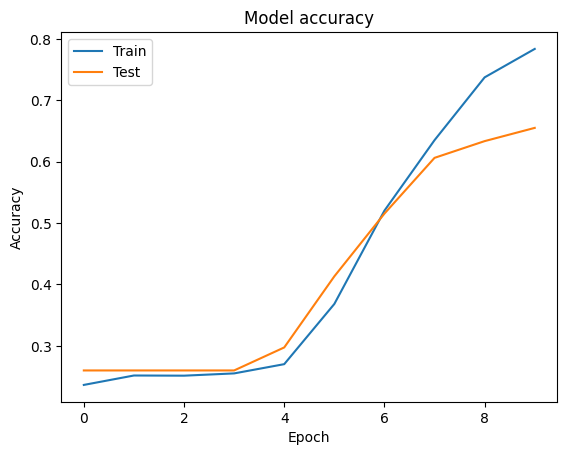

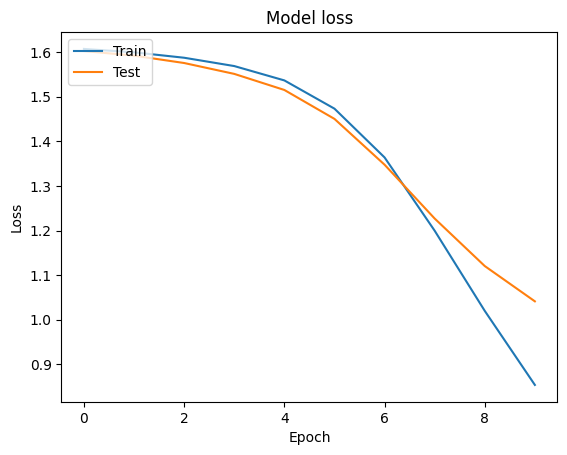

In [395]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

28/28 [==============================] - 1s 22ms/step


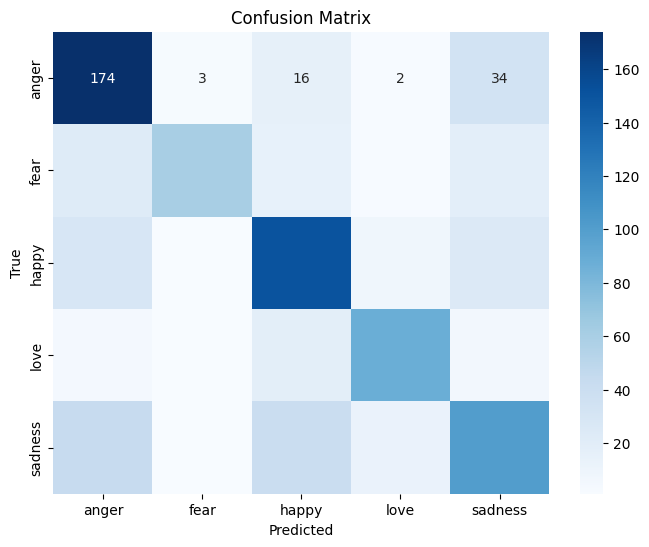

In [389]:
import seaborn as sns
from sklearn.metrics import confusion_matrix


y_pred_probs = model.predict(X_test_tfidf_reshaped)
y_pred_labels = np.argmax(y_pred_probs, axis=1)
y_true_labels = np.argmax(y_test_one_hot, axis=1)
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

emotion_labels = ['anger', 'fear', 'happy', 'love', 'sadness']

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=emotion_labels, 
            yticklabels=emotion_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()